## Spectra stacking 

### Not sure, but i will stack all the spectra from its peak.

In [2]:
from astropy.io import ascii
import numpy as np
import Tools
import matplotlib.pyplot as plt
import importlib
import seaborn as sns

No handles with labels found to put in legend.


FWHM: 25.662566256625666
FWHM based on std: 29.331100190597894


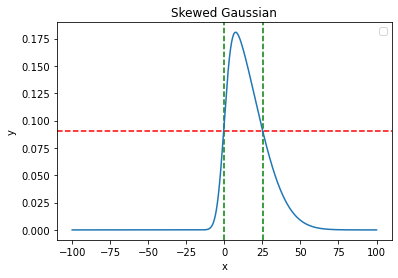

In [3]:
import numpy as np
from scipy.special import erf

import matplotlib.pyplot as plt

def skewed_gaussian(x, mu, sigma, alpha):
    """Skewed Gaussian function"""
    return (2 / sigma) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) * (1 + erf(alpha * (x - mu) / (np.sqrt(2) * sigma)))

# Parameters
mu = 0
sigma = 20
alpha = 5  # Skewness parameter

delta=alpha/np.sqrt(1+alpha**2)
std=np.sqrt(sigma**2 * (1-2*delta**2/np.pi))
# Generate x values
x = np.linspace(-100, 100, 10000)

# Generate y values
y = skewed_gaussian(x, mu, sigma, alpha)


# Calculate FWHM
half_max = np.max(y) / 2
indices = np.where(y > half_max)[0]
fwhm = x[indices[-1]] - x[indices[0]]
print(f"FWHM: {fwhm}")

# Calculate FWHM based on sigma
fwhm_std = 2 * np.sqrt(2 * np.log(2)) * std
print(f"FWHM based on std: {fwhm_std}")

# Plot the FWHM
plt.axhline(y=half_max, color='r', linestyle='--')
plt.axvline(x=x[indices[0]], color='g', linestyle='--')
plt.axvline(x=x[indices[-1]], color='g', linestyle='--')
# Plot
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Skewed Gaussian')
plt.legend()
plt.show()

In [4]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")


In [5]:
Catalog=Catalog[Catalog["EWLya"]>0]

In [6]:
from scipy.stats import ks_2samp

mask=Catalog["Type"]=="LAE"

print(np.median(Catalog[mask]["slope"]))
print(np.median(Catalog[~mask]["slope"]))

# Perform KS test
ks_statistic, p_value = ks_2samp(Catalog[mask]["Muv"], Catalog[~mask]["slope"])

print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

-2.025321013754498
-1.8497135569649663
KS Statistic: 1.0
P-value: 2.220446049250313e-16


#### Load Catalog and 1D data, mask 1D data 

I mask it to keep only the LAEs I will put on paper (No bad fits or low S/N<3)

In [7]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Data=np.transpose(np.load("../B-CalibrationCode/1D/1D_data.npy",allow_pickle=True))
LAEid=Catalog[Catalog["Type"]=="LAE"]["id_charlotte"]
Catalog = Catalog[np.isin(Catalog['id_charlotte'], LAEid)]
mask = np.isin(Data[0], LAEid)
Data=np.transpose(Data)[mask]
snFile=np.load("../B-CalibrationCode/SNR.npy",allow_pickle=True)


wave_lya=[]
redshift=[]
skewness=[]
Snr=[]
for ID in np.transpose(Data)[0]:
    skewness.append(Catalog[Catalog["id_charlotte"] == ID]["Skewness"][0])
    for i in range(len(snFile)):
        if snFile[i][0] == ID:
            Snr.append(float(snFile[i][1]))
            break
    z = Catalog[Catalog["id_charlotte"] == ID]["z"]
    redshift.append(z[0])
    wave_lya.append(1215.3*(1+z))
redshift=np.array(redshift)
wave_lya=np.array(wave_lya)
skewness=np.array(skewness)
Snr=np.array(Snr)



#### Put all data in a 101 size array where element 

##### Middle is array[50]

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.1034666 ,
        0.2018709 , 0.        , 0.        , 0.16501822, 0.03080259,
        0.02868387, 0.        , 0.        , 0.        , 0.10349914,
        0.        , 0.        , 0.        , 0.08594889, 0.        ,
        0.        , 0.        , 0.34570173, 0.20741071, 0.12006577,
        0.        , 0.        , 0.06280421, 0.18098731, 0.35622799,
        0.32042274, 0.58251206, 0.78914083, 0.49824995, 0.0479836 ,
        0.23230875, 0.36585692, 0.36119529, 0.36254456, 0.1348817 ,
        0.14752917, 0.        , 0.20007489, 0.21150497, 0.2737425 ,
        0.17330205, 0.        , 0.        , 0.        , 0.05446906,
        0.13391699, 0.01907492, 0.        , 0.02392007, 0.15234914,
        0.09805509, 0.10131137, 0.09721884, 0.08165804, 0.22889106,
        0.1386991 , 0.        , 0.        , 0.  

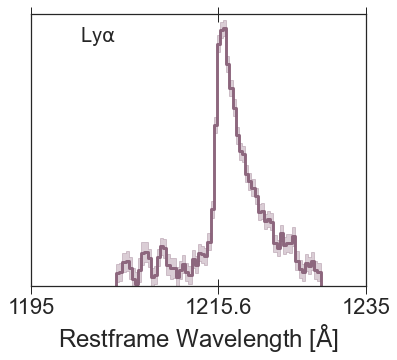

In [8]:
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
cmap = ListedColormap(Antique_3.mpl_colors)

sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (6,5)
fig, axs = plt.subplots()


StackObj=Tools.StackSpectra(np.transpose(Data)[1],np.transpose(Data)[2],np.transpose(Data)[3])
StackObj.maskCentralWave(wave_lya,50,20)
StackObj.makeArray(size=101,resolution=0.62/(1+5.6))
StackObj.stack()
flux=StackObj.stacked_spectra/max(StackObj.stacked_spectra)
err=StackObj.stacked_err/max(StackObj.stacked_spectra)
axs.step(StackObj.stacked_wave,flux,color=cmap(0.1),lw=3,alpha=0.9,where='mid')
axs.fill_between(StackObj.stacked_wave,flux-err,flux+err , color=cmap(0.1), alpha=0.3,step='mid')

axs.tick_params(axis='both', direction='inout', length=15, width=1, which='both', top=True, right=True)  # Set the length and width of the ticks

axs.set_xlabel(r"Restframe Wavelength [$\mathrm{\AA}$]")
axs.set_yticks([])
axs.set_xticks([1210,1215.6,1220])
axs.set_ylim(0.05,1.05)
axs.set_xticklabels(['1195', '1215.6', '1235'])
axs.set_xlim(1210,1220)
axs.text(1212, 0.95, r"Ly$\mathrm{\alpha}$", fontsize=20, ha='center')
plt.savefig("../G-Plots/MakeFigures/Figures/StackedSpectra.pdf",bbox_inches='tight')



NameError: name 'FracPercentage' is not defined

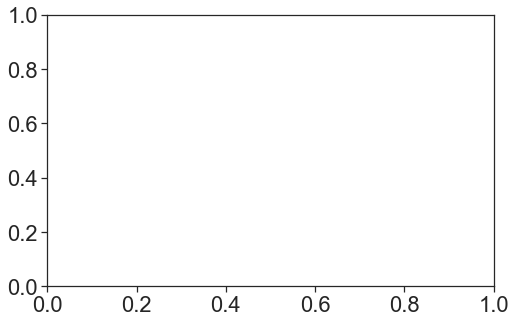

In [9]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 5)
fig, axs = plt.subplots()

axs.step(range(len(FracPercentage)), FracPercentage, where='mid', color='#342E31', lw=2)
axs.fill_between(range(len(FracPercentage)), FracPercentage, step='mid', alpha=0.3, color='#342E31')
axs.set_xlabel("Bin")
axs.set_ylabel("Asymmetric Fraction")
axs.set_xticks(range(len(FracPercentage)))
axs.set_xticklabels(range(len(FracPercentage)))
axs.set_ylim(0, 1)

plt.show()


TypeError: maskCentralWave() missing 1 required positional argument: 'extractarea'

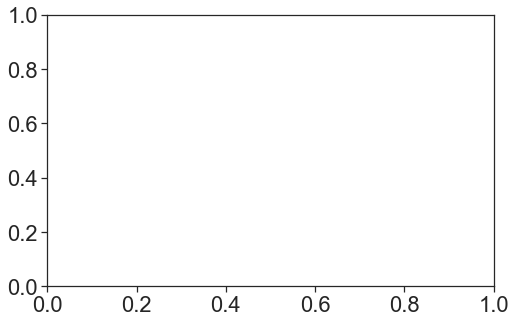

In [10]:
importlib.reload(Tools)
cmap = plt.cm.get_cmap('Purples')


#mask: the redshift of which galaxies to include

mask_noEOR=redshift<=5.66

sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (8,5)
fig, axs = plt.subplots()


StackObj=Tools.StackSpectra(np.transpose(Data)[1][mask_noEOR],np.transpose(Data)[2][mask_noEOR],np.transpose(Data)[3][mask_noEOR])
StackObj.maskCentralWave(wave_lya[mask_noEOR],50)
StackObj.loadSNR(Snr[mask_noEOR])
StackObj.maskLowSNR(5)
StackObj.makeArray(size=101)
StackObj.stack()
axs.plot(StackObj.stacked_wave,StackObj.stacked_spectra/max(StackObj.stacked_spectra),color='#342E31',lw=3,alpha=0.5)

StackObj=Tools.StackSpectra(np.transpose(Data)[1][~mask_noEOR],np.transpose(Data)[2][~mask_noEOR],np.transpose(Data)[3][~mask_noEOR])
StackObj.maskCentralWave(wave_lya[~mask_noEOR],50)
StackObj.loadSNR(Snr[~mask_noEOR])
StackObj.maskLowSNR(5)
StackObj.makeArray(size=101)
StackObj.stack()
axs.plot(StackObj.stacked_wave,StackObj.stacked_spectra/max(StackObj.stacked_spectra),color=cmap(0.6),lw=3,alpha=0.7)

axs.set_xlabel("Restframe Wavelength")
axs.tick_params(axis='both', direction='inout', length=15, width=1, which='both', top=True, right=True)  # Set the length and width of the ticks
#axs.set_xlim(1191,1239)
axs.set_ylim(-0.05,1.05)
axs.set_yticks([0, 0.5, 1])
plt.show()

In [11]:
import importlib



importlib.reload(Tools)

StackObj=Tools.StackSpectra(np.transpose(Data)[1][~mask_noEOR],np.transpose(Data)[2][~mask_noEOR],np.transpose(Data)[3][~mask_noEOR])
StackObj.maskCentralWave(wave_lya[~mask_noEOR],50)
StackObj.loadSNR(Snr[~mask_noEOR])
StackObj.maskLowSNR(8)
StackObj.makeArray(size=101)
StackObj.stack()
plt.plot(StackObj.stacked_wave,StackObj.stacked_spectra/max(StackObj.stacked_spectra),color='#342E31',lw=3,alpha=0.5)
plt.show()
#StackObj.plotSpectra()

TypeError: maskCentralWave() missing 1 required positional argument: 'extractarea'

In [12]:
a=1
d=a/np.sqrt(1+a**2)
print(d)

0.7071067811865475


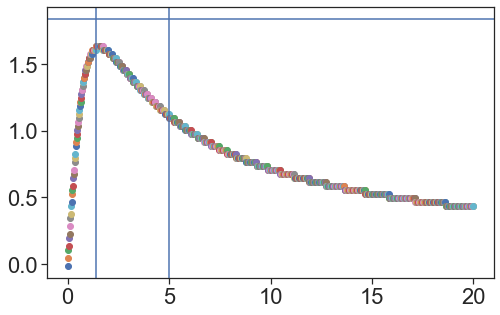

1.103603603603574
1.4014014014014013
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


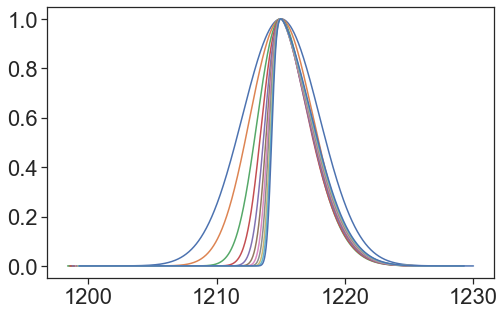

In [13]:
from scipy.interpolate import interp1d

import scipy.special as scispe

skewness=np.load("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/B-CalibrationCode/skewness.npy",allow_pickle=True)
skewness_dict = skewness.item()



def skewed_gaussian(x,mu,sigma,g,C) :
    """Gaussian"""
    return np.exp( -0.5 * (x-mu)**2 / sigma**2)* (1+scispe.erf( g*(x-mu)/(sigma*np.sqrt(2)))) + C


x=np.linspace(1200,1230,1000)
gs=np.linspace(0,20,1000)


center=1215
diff=[]
for g in gs:
    y=skewed_gaussian(x,1215,3,g,0)
    xpeak=x[np.argmax(y)]   
    plt.plot(g,xpeak-center,"o")
    diff.append(xpeak-center)

plt.axvline(x=5)
plt.axhline(y=1.84)
plt.axvline(x=1.4)
plt.show()

interp_func = interp1d(gs, diff, kind='linear')
print(interp_func(5))

max_diff_index = np.argmax(diff)
g_max_diff = gs[max_diff_index]
print(g_max_diff)

gs=np.linspace(0,10,11)
print(gs)
for g in gs:
    interpolate_dif=interp_func(g)
    y=skewed_gaussian(x,1215,3,g,0)
    plt.plot(x-interpolate_dif,y/max(y))
plt.show()



Galaxies per bin: 16


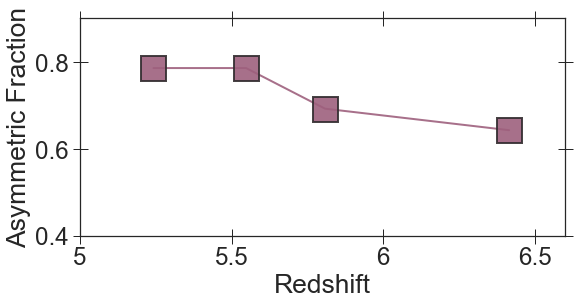

In [14]:
plt.rcParams["figure.figsize"] = (9,4.)
kwsLAE = dict(linewidth=2, marker="s", markeredgecolor="#342E31", color='#9e607d', alpha=0.9, markeredgewidth=2, markersize=25, zorder=100, label=r"Ly-$\alpha$ Detected")

import pandas as pd
skewness=np.load("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/B-CalibrationCode/skewness.npy",allow_pickle=True)
skewness= skewness.item()
snFile=np.load("../B-CalibrationCode/SNR.npy",allow_pickle=True)

Skewness=[]
redshift=[]
SNR=[]
for id,skew in zip(skewness["ID"],skewness["g"]):
    try:
        gal= Catalog[Catalog["id_charlotte"]==id]
        z=gal["z"]
        redshift.append(z.value[0])
        Skewness.append(skew)
        s=0
        for i in range(len(snFile)):
            if snFile[i][0] == id:
                SNR.append(float(snFile[i][1]))
                s=1
        if s==0:
            SNR.append(30)
        

    except:
        continue
assert len(Skewness)==len(redshift), "Not same size Skewness, and redshift"
assert len(Catalog)==len(redshift), "Not same size to original Catalog"

n = 4
CutSkewness=3
CutSNR=5
bins = pd.qcut(redshift, q=n, labels=False, retbins=True)[1]
print("Galaxies per bin:", int(len(redshift)/n))


zs = [(bins[i] + bins[i+1]) / 2 for i in range(0, len(bins)-1)]
Frac = [[] for _ in range(0, len(bins)-1)]


for sk, z,snr in zip(Skewness, redshift,SNR):
    if snr<CutSNR:
        continue
    for i in range(0, len(bins)-1):
        if z > bins[i] and z < bins[i+1]:
            if sk >= CutSkewness:
                Frac[i].append(1)
            if sk < CutSkewness:
                Frac[i].append(0)

Skewness_in_bin = [[] for _ in range(0, len(bins)-1)]
for sk, z in zip(Skewness, redshift):
    for i in range(0, len(bins)-1):
        if z > bins[i] and z < bins[i+1]:
            Skewness_in_bin[i].append(sk)

FracPercentage = [my_array.count(1) / len(my_array) for my_array in Frac]

plt.rcParams["figure.figsize"] = (8.7,4.)
sns.set_theme(style="ticks",font_scale=2.2)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', direction='inout', length=15, width=1, which='both', top=True, right=True)
ax.plot(zs, FracPercentage, **kwsLAE)
ax.set_ylabel(r"Asymmetric Fraction")
ax.set_xlabel(r"Redshift")
ax.set_ylim(0.4, 0.9)
ax.set_xlim(5, 6.6)
ax.set_xticks([5, 5.5, 6,6.5])
ax.set_xticklabels([5, 5.5, 6,6.5])
#plt.savefig("Figures/Skew_Fraction.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [15]:
import random
PosteriorsFile=np.load("../B-CalibrationCode/AllDist.npy",allow_pickle=True)
sks=[]
ids=[]
for gal in PosteriorsFile:
    id=gal[2]["ID"]
    ids.append(id)
    sk=10**gal[0]["g"]
    random_elements = random.choices(sk, k=1000)
    sks.append(random_elements)
sks=np.array(sks).T





In [16]:
len(skewness["g"])

69

In [ ]:
plt.rcParams["figure.figsize"] = (9,4.)
kwsLAE = dict(linewidth=2, marker="s", markeredgecolor="#342E31", color='#9e607d', alpha=0.9, markeredgewidth=2, markersize=25, zorder=100, label=r"Ly-$\alpha$ Detected")

import pandas as pd

snFile=np.load("../B-CalibrationCode/SNR.npy",allow_pickle=True)


All_frac=[]
for attempt in range(500):
    Skewness=[]
    redshift=[]
    SNR=[]
    skewness={"ID":ids,"g":sks[attempt]}
    for id,skew in zip(skewness["ID"],skewness["g"]):
        try:
            gal= Catalog[Catalog["id_charlotte"]==id]
            z=gal["z"]
            redshift.append(z.value[0])
            Skewness.append(skew)
            s=0
            for i in range(len(snFile)):
                if snFile[i][0] == id:
                    SNR.append(float(snFile[i][1]))
                    s=1
            if s==0:
                print(id)
                SNR.append(30)
            

        except:
            continue
    assert len(Skewness)==len(redshift), "Not same size Skewness, and redshift"
    
    n = 4
    CutSkewness=3
    CutSNR=5
    bins = pd.qcut(redshift, q=n, labels=False, retbins=True)[1]

    zs = [(bins[i] + bins[i+1]) / 2 for i in range(0, len(bins)-1)]
    Frac = [[] for _ in range(0, len(bins)-1)]


    for sk, z,snr in zip(Skewness, redshift,SNR):
        if snr<CutSNR:
            continue
        for i in range(0, len(bins)-1):
            if z > bins[i] and z < bins[i+1]:
                if sk >= CutSkewness:
                    Frac[i].append(1)
                if sk < CutSkewness:
                    Frac[i].append(0)

    Skewness_in_bin = [[] for _ in range(0, len(bins)-1)]
    for sk, z in zip(Skewness, redshift):
        for i in range(0, len(bins)-1):
            if z > bins[i] and z < bins[i+1]:
                Skewness_in_bin[i].append(sk)

    FracPercentage = [my_array.count(1) / len(my_array) for my_array in Frac]
    All_frac.append(FracPercentage)
    
    if attempt % 10 == 0:
        print("Attempt:", attempt)

Attempt: 0
Attempt: 10
Attempt: 20
Attempt: 30
Attempt: 40
Attempt: 50
Attempt: 60
Attempt: 70
Attempt: 80
Attempt: 90
Attempt: 100
Attempt: 110
Attempt: 120
Attempt: 130
Attempt: 140
Attempt: 150
Attempt: 160
Attempt: 170


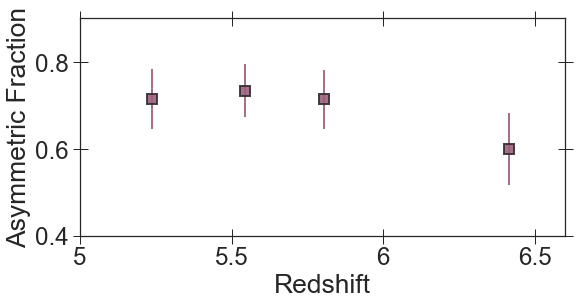

In [ ]:
import numpy as np

All_frac_transposed = np.transpose(All_frac)
median_values = np.median(All_frac_transposed, axis=1)
std_values = np.std(All_frac_transposed, axis=1)
kwsLAE = dict(linewidth=2, marker="s", markeredgecolor="#342E31", color='#9e607d', alpha=0.9, markeredgewidth=2, markersize=10, zorder=100, label=r"Ly-$\alpha$ Detected")

plt.rcParams["figure.figsize"] = (8.7,4.)
sns.set_theme(style="ticks",font_scale=2.2)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.tick_params(axis='both', direction='inout', length=15, width=1, which='both', top=True, right=True)
ax.errorbar(zs, median_values, yerr=std_values, fmt='o',**kwsLAE)
ax.set_ylabel(r"Asymmetric Fraction")
ax.set_xlabel(r"Redshift")
ax.set_ylim(0.4, 0.9)
ax.set_xlim(5, 6.6)
ax.set_xticks([5, 5.5, 6,6.5])
ax.set_xticklabels([5, 5.5, 6,6.5])
#plt.savefig("Figures/Skew_Fraction.pdf", dpi=200, bbox_inches="tight")
plt.show()

In [ ]:
f=ascii.read("../A-Catalogs/velocity_offsets/Tang24.txt")

In [ ]:
mask=f["Muv"]<-20

In [ ]:
np.mean(f[mask]["voff"])

327.6666666666667

In [ ]:
Catalog

id_candels,id_charlotte,ra_candels,dec_candels,KPNO_U_FLUX,LBC_U_FLUX,ACS_F435W_FLUX,ACS_F606W_FLUX,ACS_F775W_FLUX,ACS_F814W_FLUX,ACS_F850LP_FLUX,WFC3_F105W_FLUX,WFC3_F125W_FLUX,WFC3_F140W_FLUX,WFC3_F160W_FLUX,KPNO_U_FLUXERR,LBC_U_FLUXERR,ACS_F435W_FLUXERR,ACS_F606W_FLUXERR,ACS_F775W_FLUXERR,ACS_F814W_FLUXERR,ACS_F850LP_FLUXERR,WFC3_F105W_FLUXERR,WFC3_F125W_FLUXERR,WFC3_F140W_FLUXERR,WFC3_F160W_FLUXERR,z,LyaFlux,LyaErr,LyaFWHM,Skewness,photoz,IDFink,FluxLim,Type,HaFlux,dHaFlux,EWHa,dEWHa,HaFWHM,dHaFWHM,fesc,dfesc,voff,dvoff,zsys,Muv,dMuv,slope,dslope,EWLya,dEWLya,LyaFWHM_int,dLyaFWHM_int,Asymmetry,inFresco,line,f090w_mag_aper_1,f090w_magerr_aper_1,f115w_mag_aper_1,f115w_magerr_aper_1,f150w_mag_aper_1,f150w_magerr_aper_1,f200w_mag_aper_1,f200w_magerr_aper_1,f277w_mag_aper_1,f277w_magerr_aper_1,f335m_mag_aper_1,f335m_magerr_aper_1,f356w_mag_aper_1,f356w_magerr_aper_1,f410m_mag_aper_1,f410m_magerr_aper_1,f444w_mag_aper_1,f444w_magerr_aper_1,Slit_loss?,f090w_mag_aper_2,f090w_magerr_aper_2,f115w_mag_aper_2,f115w_magerr_aper_2,f150w_mag_aper_2,f150w_magerr_aper_2,f200w_mag_aper_2,f200w_magerr_aper_2,f277w_mag_aper_2,f277w_magerr_aper_2,f335m_mag_aper_2,f335m_magerr_aper_2,f356w_mag_aper_2,f356w_magerr_aper_2,f410m_mag_aper_2,f410m_magerr_aper_2,f444w_mag_aper_2,f444w_magerr_aper_2,f090w_tot_2,f090w_etot_2,f115w_tot_2,f115w_etot_2,f150w_tot_2,f150w_etot_2,f200w_tot_2,f200w_etot_2,f277w_tot_2,f277w_etot_2,f335m_tot_2,f335m_etot_2,f356w_tot_2,f356w_etot_2,f410m_tot_2,f410m_etot_2,f444w_tot_2,f444w_etot_2,f435w_tot_2,f435w_etot_2,f606w_tot_2,f606w_etot_2,f770w_tot_2,f770w_etot_2,f775w_tot_2,f775w_etot_2,f814w_tot_2,f814w_etot_2,f850lp_tot_2,f850lp_etot_2,f105w_tot_2,f105w_etot_2,f110w_tot_2,f110w_etot_2,f125w_tot_2,f125w_etot_2,f140w_tot_2,f140w_etot_2,f160w_tot_2,f160w_etot_2,f_F160W,e_F160W,f_U,e_U,f_F435W,e_F435W,f_B,e_B,f_G,e_G,f_V,e_V,f_F606W,e_F606W,f_R,e_R,f_Rs,e_Rs,f_I,e_I,f_F775W,e_F775W,f_Z,e_Z,f_F850LP,e_F850LP,f_F125W,e_F125W,f_J,e_J,f_F140W,e_F140W,f_H,e_H,dLyaFWHM
int64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str12,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str8,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
21131,z6_GNW_25971,189.334732,62.286125,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,5.954901543252334,-17.172234570388177,-17.885015814798304,196.27199098376076,0.1859498259397983,6.1,nan,nan,LAE,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-19.74657453565378,0.4676423756915451,-1.9465405045141178,1.284059533619354,38.12697190529507,32.18618958546328,194.35597764666383,39.70863487279328,5.325694002849099,noFresco,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,24.703933667699914,0.006830766561382262,nan,nan,24.61103211876343,0.008008920199950254,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,24.51678281002

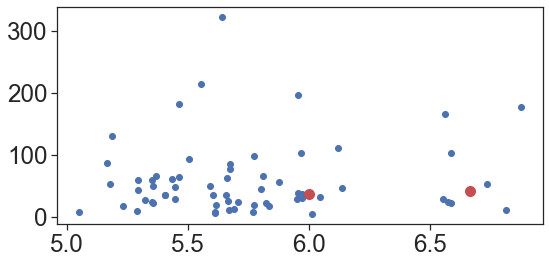

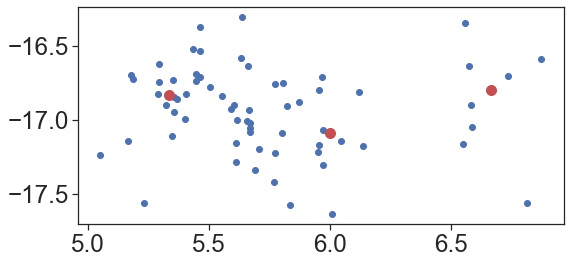

In [ ]:
plt.scatter(Catalog["z"],Catalog["EWLya"])

bins=np.linspace(5,7,4)
median_values = []
for i in range(len(bins)-1):
    mask = (Catalog['z'] > bins[i]) & (Catalog['z'] <= bins[i+1])
    median = np.median(Catalog['EWLya'][mask])
    median_values.append(median)
    
midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.scatter(midpoints,median_values,c='r',s=100)
plt.show()

plt.scatter(Catalog["z"],Catalog["LyaFlux"])

bins=np.linspace(5,7,4)
median_values = []
for i in range(len(bins)-1):
    mask = (Catalog['z'] > bins[i]) & (Catalog['z'] <= bins[i+1])
    median = np.median(Catalog['LyaFlux'][mask])
    median_values.append(median)
    
midpoints = [(bins[i] + bins[i+1]) / 2 for i in range(len(bins)-1)]
plt.scatter(midpoints,median_values,c='r',s=100)
plt.show()

In [ ]:
median_values

[-16.834072717991887, -17.088135076949346, -16.802598312053107]

In [ ]:
skewness=np.load("/Users/gonzalo/Desktop/Code/Gonzalo_Binospec/A-Project/B-CalibrationCode/skewness.npy",allow_pickle=True)
skewness_dict = skewness.item()

### Stacking ones with voff


In [1]:
from astropy.io import ascii
import numpy as np
import Tools
import matplotlib.pyplot as plt
import importlib
import seaborn as sns
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
cmap = ListedColormap(Antique_3.mpl_colors)

In [2]:
def angstromTokms(centralA,As):
    c=299792
    v=c*(As-centralA)/centralA
    return v+c

def angstromTokms2(centralA,As):
    c=299792
    v=c*(As-centralA)/centralA
    return v
    
def kmsToangstrom(v,centralA):
    c=299792
    As = centralA*(v+c)/c
    return As-centralA

def kmsToangstrom2(v,centralA):
    c=299792
    As = centralA*(v+c)/c
    return centralA-As

In [3]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
Catalog=Catalog[np.isnan(Catalog["zsys"])==False]
Catalog=Catalog[Catalog["Type"]=="LAE"]
print(Catalog["id_charlotte"])

    id_charlotte   
-------------------
       z6_GNW_14511
       z6_GND_36100
       z6_GND_43125
        z7_GND_8358
       z5_GND_39445
       z5_GND_27819
       z5_GND_21153
       z5_GND_17752
   Stark11_33_17705
   Stark11_34_24923
Jung18_z6_GND_28438


In [4]:
Catalog=ascii.read("../A-Catalogs/Binospec-Candels.cat")
#Catalog=Catalog[np.isnan(Catalog["zsys"])==False]
Catalog=Catalog[Catalog["id_charlotte"]=="z6_GND_43125"]

Data=np.transpose(np.load("../B-CalibrationCode/1D/1D_data.npy",allow_pickle=True))

LAEid=Catalog[Catalog["Type"]=="LAE"]["id_charlotte"]
Catalog = Catalog[np.isin(Catalog['id_charlotte'], LAEid)]
mask = np.isin(Data[0], LAEid)
Data=np.transpose(Data)[mask]



wave_lya=[]
for ID in np.transpose(Data)[0]:
    z = Catalog[Catalog["id_charlotte"] == ID]["z"]
    wave_lya.append(1215.6*(1+z))


In [5]:
z=np.median(Catalog["zsys"])
velocities=[-1000,-700,-300,0,300,700,1000]
waves=[kmsToangstrom(v,1215.6)+1215. for v in velocities]


In [6]:
Free=[6000,10000]
out=[[9490,9500],[7000,7910],[8000,10000],Free,[7000,8280],Free,[7827,8500],[8440,8453],[8028,9000],Free,Free]

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.06253948, 0.12709473,
        0.        , 0.11490756, 0.05400649, 0.        , 0.07489709,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.41154959, 0.07790934, 0.        ,
        0.14300544, 0.14473206, 0.10861675, 0.        , 0.03060604,
        0.        , 0.16839879, 0.20840586, 0.22273734, 0.        ,
        0.35091245, 0.83541983, 0.54455698, 1.02222329, 0.49049018,
        0.38503153, 0.28352184, 0.44888514, 0.28059694, 0.21757539,
        0.13623186, 0.24457738, 0.2496253 , 0.48

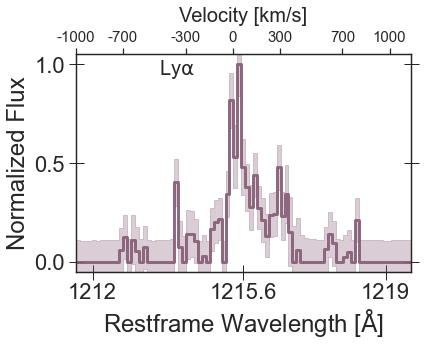

In [7]:
importlib.reload(Tools)


sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (6,4)

StackObj=Tools.StackSpectra(np.transpose(Data)[1],np.transpose(Data)[2],np.transpose(Data)[3])

StackObj.maskCentralWave(wave_lya,80,20)

StackObj.makeArray(size=161,resolution=0.62/(1+5.6))

StackObj.stack()

flux=StackObj.stacked_spectra/max(StackObj.stacked_spectra)
err=StackObj.stacked_err/max(StackObj.stacked_spectra)


fig, axs = plt.subplots()

axs.step(StackObj.stacked_wave,(flux),color=cmap(0.1),lw=3,alpha=0.9,where='mid')
axs.fill_between(StackObj.stacked_wave,(flux-err),(flux+err) , color=cmap(0.1), alpha=0.3,step='mid')
axs.tick_params(axis='both', direction='inout', length=15, width=1, which='both', top=True, right=True)  # Set the length and width of the ticks







axs.set_xlabel(r"Restframe Wavelength [$\mathrm{\AA}$]")
axs.set_yticks([0,0.5,1])
axs.set_xticks(np.array([1212,1215.6,1219]))
axs.set_ylim(-0.05,1.05)
axs.set_xticklabels(['1212', '1215.6', '1219'])
axs.set_xlim(1211.6,1219.6)

#plt.axvline(x=1215.6,ls='--',color='k')

ax2 = axs.twiny()
ax2.set_xlim(axs.get_xlim())
ax2.set_xticks(waves)
ax2.set_xticklabels(velocities,fontsize=15)

ax2.xaxis.set_label_coords(0.5, 1.15)
ax2.set_xlabel('Velocity [km/s]',fontsize=20)   

axs.set_ylabel("Normalized Flux")
axs.text(1214, 0.95, r"Ly$\mathrm{\alpha}$", fontsize=20, ha='center')
plt.savefig("../G-Plots/MakeFigures/Figures/StackedSpectra.pdf",bbox_inches='tight')
plt.show()

In [8]:
w=StackObj.stacked_wave
f=flux

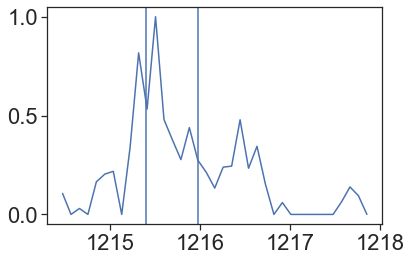

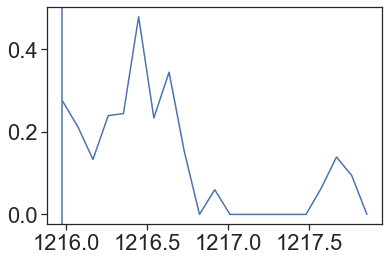

0.3486553239851622


In [10]:
START=-1
END=2.5
velocity=0.575
Lya=1215.4
mask=(w>Lya+START) & (w<Lya+END)
plt.plot(w[mask],f[mask])
plt.axvline(Lya)
plt.axvline(Lya+velocity)
plt.show()
total_flux=np.sum(f[mask])
mask=(w>Lya+velocity) & (w<Lya+END)
plt.plot(w[mask],f[mask])

plt.axvline(Lya+velocity)
red_flux=np.sum(f[mask])
plt.show()

print(red_flux/total_flux)

In [11]:
kmsToangstrom(400-258+125,1215.6)

1.0826346266744622

In [37]:
RESULTS=[10,37,3,5,20,30,5,62,15,35]
print(np.median(RESULTS),np.std(RESULTS))

17.5 17.870646322950943


In [31]:
axs.get_xlim()

(1211.6, 1219.6)

[array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.10891452,
        0.        , 0.        , 0.        , 0.43807355, 0.26283104,
        0.15214745, 0.        , 0.        , 0.07958556, 0.22934729,
        0.45141244, 0.40604   , 0.73815983, 1.        , 0.6313828 ,
        0.06080487, 0.29438186, 0.46361423, 0.45770701, 0.4594168 ,
        0.17092221, 0.1869491 , 0.        , 0.25

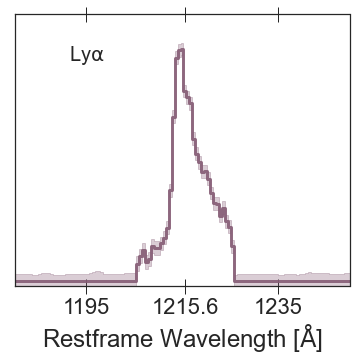

In [52]:
from palettable.cartocolors.qualitative import Antique_3
from matplotlib.colors import ListedColormap
cmap = ListedColormap(Antique_3.mpl_colors)


sns.set_theme(style="ticks",font_scale=2)
plt.rcParams["figure.figsize"] = (6,5)
fig, axs = plt.subplots()




StackObj=Tools.StackSpectra(np.transpose(Data)[1],np.transpose(Data)[2],np.transpose(Data)[3])
StackObj.maskCentralWave(wave_lya,100,extractarea=50)
StackObj.makeArray(size=201)
StackObj.stack()
flux=StackObj.stacked_spectra/max(StackObj.stacked_spectra)
err=StackObj.stacked_err/max(StackObj.stacked_spectra)
axs.step(StackObj.stacked_wave,flux,color=cmap(0.1),lw=3,alpha=0.9,where='mid')
axs.fill_between(StackObj.stacked_wave,flux-err,flux+err , color=cmap(0.1), alpha=0.3,step='mid')

axs.tick_params(axis='both', direction='inout', length=15, width=1, which='both', top=True, right=True)  # Set the length and width of the ticks

axs.set_xlabel(r"Restframe Wavelength [$\mathrm{\AA}$]")
axs.set_yticks([])
axs.set_xticks([1195,1215.6,1235])
axs.set_ylim(-0.02,1.15)
axs.set_xticklabels(['1195', '1215.6', '1235'])
axs.set_xlim(1180,1250)
axs.text(1195, 0.95, r"Ly$\mathrm{\alpha}$", fontsize=20, ha='center')
plt.savefig("../G-Plots/MakeFigures/Figures/StackedSpectra.pdf",bbox_inches='tight')


In [33]:
import numpy as np
SlitLoss=np.load("../A-Catalogs/slit_losses.npy",allow_pickle=True).tolist()


FileNotFoundError: [Errno 2] No such file or directory: '../A-Catalogs/slit_losses.npy'